In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import joblib
import os
import re
import json
from tqdm import tqdm_notebook
import gensim
import pymorphy2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
DIR_PATH = '/Users/anton.andreytsev/Desktop/Avito_catagory_classification/'

Загрузка данных

In [4]:
dat = pd.read_csv(os.path.join(DIR_PATH, 'avito_train.csv'))
cat_descr = pd.read_csv(os.path.join(DIR_PATH, 'avito_category.csv'))
dat['category_name'] = dat.category_id.map(dict(zip(cat_descr.category_id, cat_descr.name)))

In [5]:
dat.head()

,item_id,title,description,price,category_id,category_name
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки


### Подготовка данных

Разобьём таргет на иерархические классы

In [8]:
# Длина самое длинной цепочти таргета
max_hierarchy_len = np.unique([len(cat_list.split('|')) for cat_list in dat.category_name.values])[-1]
dat['category_1'] = None
dat['category_2'] = None
dat['category_3'] = None
dat['category_4'] = None
splitted_categories = []
for i in tqdm_notebook(range(dat.shape[0])):
    split_categories = dat.category_name[i].split('|')
    splitted_categories.append(split_categories + [None for j in range(max_hierarchy_len - len(split_categories))])
dat[['category_1', 'category_2', 'category_3', 'category_4']] = splitted_categories
del splitted_categories

Загрузим список стоп-слов https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json

In [10]:
morph = pymorphy2.MorphAnalyzer()

In [292]:
stop_words_set = set(json.load(open(os.path.join(DIR_PATH, 'stopwords-ru.json'), mode='r', encoding='utf-8')))
stop_words_lemm_set = set()
for word in stop_words_set:
    lemm_word = morph.parse(word)[0].normal_form
    if lemm_word not in stop_words_lemm_set:
        stop_words_lemm_set = stop_words_lemm_set.union([lemm_word])
stop_words_lemm_set = stop_words_lemm_set.union(['продать', "купить", "скидка", "выгодно", "предложение", "подробность", 
                                                 "недорого", 'состояние', 'размер', "рубль", "отличный", "сантиметр", "цена", 
                                                "комплект", "мм", "см", "продавать", "торг", "доставка", "цвета", "звонить", "вес", 
                                                 "товар", 'любой', "продаваться", "качество", "продать"])
# Эти слова есть в названиях категорий
if "дом" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['дом'])
if "книга" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['книга'])
if "другой" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['другой'])
if "дверь" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['дверь'])

Пример стоп-слов

In [12]:
print(list(stop_words_lemm_set)[:12])

['один', 'посреди', 'случай', 'являться', 'сторона', 'сразу', 'вокруг', 'даром', 'хоть', 'по', 'мож', 'никто']


Лемматизируем категории

In [205]:
all_categories = dat.category_1.value_counts().keys().tolist() + \
dat.category_2.value_counts().keys().tolist() + \
dat.category_3.value_counts().keys().tolist() + \
dat.category_4.value_counts().keys().tolist()
cat_processed_cat_dict = {}
regexp_pattern = r'[_,.!><?"@#$%^&*\t():»«+-0123456789]'
for category in all_categories:
    sentence = re.sub(regexp_pattern, ' ', category.lower()).split()
    processed_category = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            processed_category += ' ' + lemm_word
    cat_processed_cat_dict[category] = processed_category.strip()
    
dat['category_1_processed'] = dat['category_1'].map(cat_processed_cat_dict)
dat['category_2_processed'] = dat['category_2'].map(cat_processed_cat_dict)
dat['category_3_processed'] = dat['category_3'].map(cat_processed_cat_dict)
dat['category_4_processed'] = dat['category_4'].map(cat_processed_cat_dict)

lemm_name = []
for full_category_name in tqdm_notebook(dat.category_name):
    current_lemm_name = ''
    for category in full_category_name.split('|'):
        current_lemm_name += cat_processed_cat_dict[category] + ' '
    lemm_name.append(current_lemm_name.strip())
dat['category_name_processed'] = lemm_name
del lemm_name

Лемматизируем тексты

In [13]:
dat['title_processed'] = None
dat['description_processed'] = None
title_processed_list = []
regexp_pattern = r'[_,.!><?"@#$%^&*\t():»«+-0123456789]'
for i in tqdm_notebook(range(len(dat))):
    sentence = re.sub(regexp_pattern, ' ', dat.title[i].lower()).split()
    current_sentense = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            current_sentense += ' ' + lemm_word
    title_processed_list.append(current_sentense.strip())
dat.title_processed = title_processed_list
del title_processed_list

description_processed_list = []
for i in tqdm_notebook(range(len(dat))):
    # убираем знаки препинания и пунктуацию
    sentence = re.sub(regexp_pattern, ' ', dat.description[i].lower()).split()
    current_sentense = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            current_sentense += ' ' + lemm_word
    description_processed_list.append(current_sentense.strip())
dat.description_processed = description_processed_list
del description_processed_list
# Составим список всех предобработанных колонок
processed_columns = np.array([col for col in dat.columns if 'processed' in col or col == 'category_id'])


In [268]:
# # Сохраняем преобразованные тексты
# dat.to_csv(os.path.join(DIR_PATH, 'lemmatized_descriptions.csv'), index=False)

In [305]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_idf = TfidfVectorizer(min_df=20, max_df=0.90)
# cou = CountVectorizer(min_df=20, max_df=0.90)
tf_idf.fit(dat.description_processed)
# cou.fit(dat.description_processed)

Wall time: 26.4 s


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=20,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [310]:
word_idf_dict = dict(sorted(dict(zip(tf_idf.get_feature_names(), tf_idf.idf_)).items(), key=lambda x: x[1], reverse=False))

Оставим в описаниях только слова из словарика tf_idf

In [332]:
sifted_description = []
for desc in tqdm_notebook(dat.description_processed):
    sifted_description.append(' '.join([word for word in desc.split() if word in tf_idf.vocabulary_]))
dat['description_processed'] = sifted_description
del sifted_description

Уберём тексты, где описание пустое

In [337]:
needed_texts = np.array([len(sentence) != 0 for sentence in dat['description_processed']])
print('Таких текстов: {}'.format((~needed_texts).sum()))

Таких текстов: 4443


In [350]:
dat = dat.loc[needed_texts]
dat.index = range(dat.shape[0])
# Сохраняем преобразованные тексты
dat.to_csv(os.path.join(DIR_PATH, 'final_processed_texts.csv'), index=False)

Разбиение на обучение, валидацию и контроль

In [351]:
# tr_indexes, valid_indexes, te_indexes = np.split(np.arange(dat.shape[0]), [int(np.floor(0.6*dat.shape[0])), int(np.floor(0.6*dat.shape[0])) + 
#                           int(np.floor(0.3*dat.shape[0]))])
# np.save(os.path.join(DIR_PATH, 'train_indexes.npy'), tr_indexes)
# np.save(os.path.join(DIR_PATH, 'valid_indexes.npy'), valid_indexes)
# np.save(os.path.join(DIR_PATH, 'test_indexes.npy'), te_indexes)
tr_indexes = np.load(os.path.join(DIR_PATH, 'train_indexes.npy'))
valid_indexes = np.load(os.path.join(DIR_PATH, 'valid_indexes.npy'))
te_indexes = np.load(os.path.join(DIR_PATH, 'test_indexes.npy'))

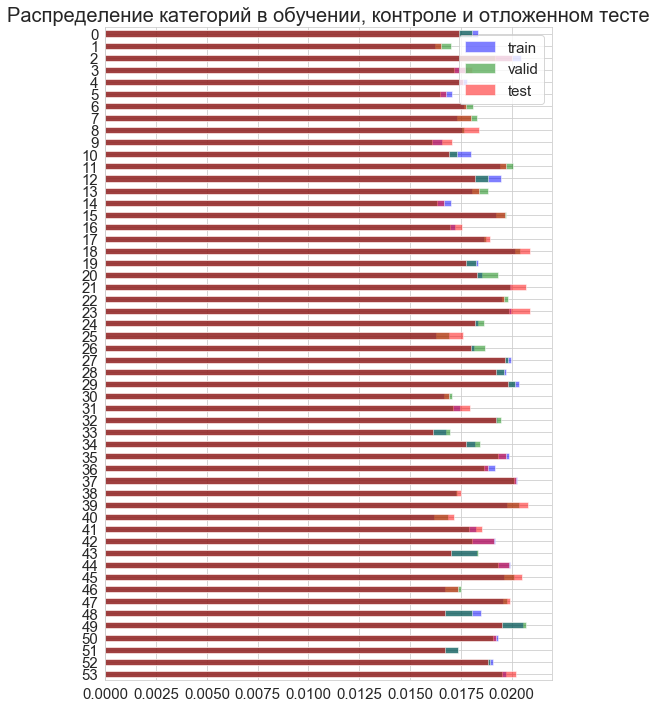

In [352]:
plt.figure(figsize=(8, 12))
plt.title('Распределение категорий в обучении, контроле и отложенном тесте', fontsize=20);
dat.category_id[tr_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='blue', alpha=0.5, label='train');
dat.category_id[valid_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='green', alpha=0.5, label='valid');
dat.category_id[te_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='red', alpha=0.5, label='test');
plt.legend(fontsize=15);

Посмотрим на распределение меток по уровням в обучении, контроле и отложенном тесте

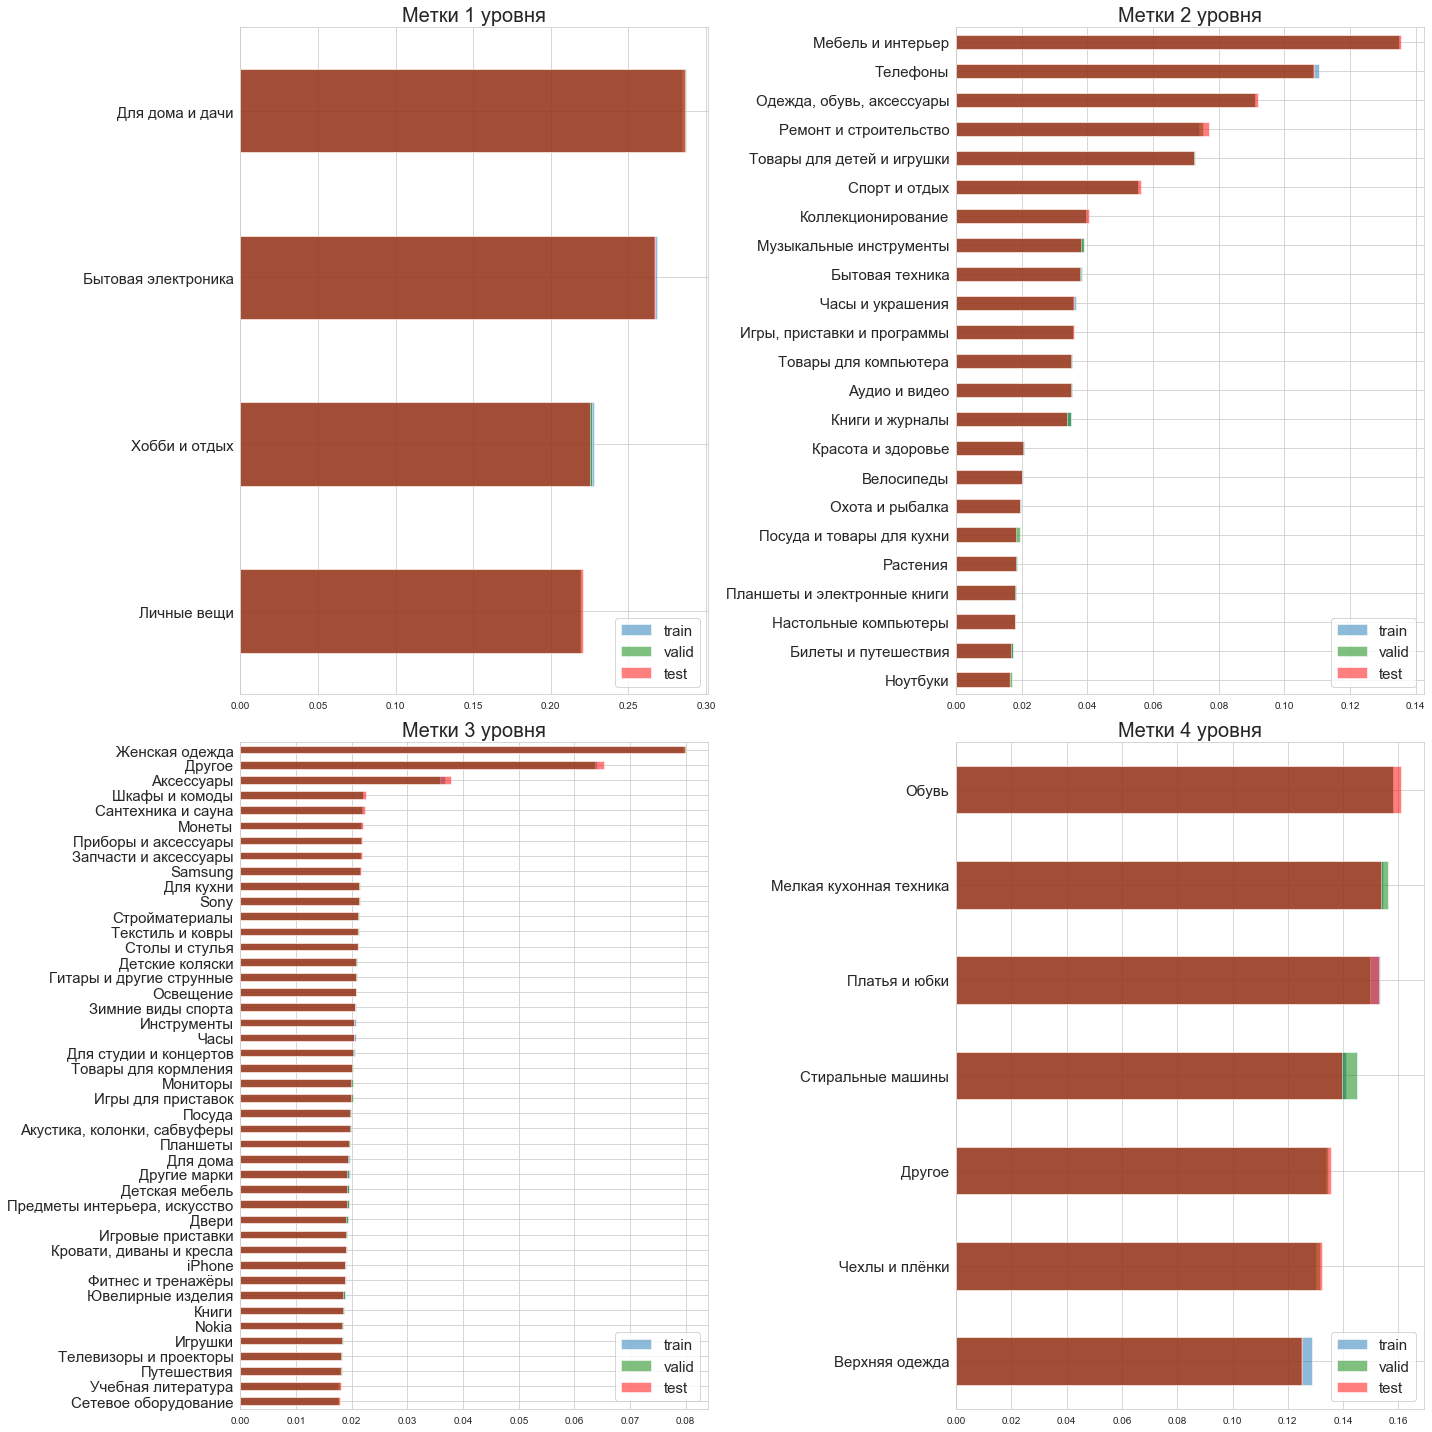

In [353]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
k = 1
for (i, j) in itertools.product(range(2), range(2)):
    dat['category_{}'.format(k)][tr_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', alpha=0.5, label='train', 
                                                                                              ax=ax[i, j])
    dat['category_{}'.format(k)][valid_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.5, 
                                                                                                 label='valid', ax=ax[i, j])
    dat['category_{}'.format(k)][te_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', color='red', alpha=0.5, 
                                                                                              label='test', ax=ax[i, j])
    plt.sca(ax[i, j])
    plt.yticks(fontsize=15);
    plt.legend(fontsize=15);
    plt.title('Метки {} уровня'.format(k), fontsize=20);
    fig.tight_layout();
    k += 1

### Модели

Загружаем предобученный w2v на русской википедии https://nlpub.mipt.ru/Russian_Distributional_Thesaurus

In [4]:
%%time
w2v_fpath = "/Users/anton.andreytsev/Downloads/tenth.norm-sz500-w7-cb0--min5.w2v"
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
w2v.init_sims(replace=True)

Wall time: 3min
